Import packages and helper functions

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
import copy
import subprocess

def threshold(diff, percentage):
    dif_1=copy.deepcopy(diff)
    dif_total_1 = copy.deepcopy(dif_1)
    thres_1_1=np.percentile(dif_1, percentage)
    thres_1_2=np.percentile(dif_1, 100-percentage)
    mask_1_1 = dif_1 < thres_1_1
    mask_1_2 = (dif_1 >= thres_1_1) & (dif_1 < thres_1_2)
    mask_1_3 = dif_1 >= thres_1_2
    dif_total_1[mask_1_2] = 0
    dif_total = dif_total_1
    return dif_total 

def normalize_words(abs_attack): 
    """normalize saliency across embd index"""
    average_attack = np.mean(abs_attack,axis = 0) #average saliency for each embd index
    normalized_attack_sq = (abs_attack-average_attack)**2
    return normalized_attack_sq

samples=["it's a glorified sitcom , and a long , unfunny one at that .",#
    "it kinda works and qualifies as cool at times , but is just too lame to work or be cool at others .",
    "it cannot be enjoyed , even on the level that one enjoys a bad slasher flick , primarily because it is dull . yes , dull .",
    "makes for a pretty unpleasant viewing experience . ",
    "the result is a gaudy bag of stale candy , something from a halloween that died . ",
    "deadeningly dull , mired in convoluted melodrama , nonsensical jargon and stiff-upper-lip laboriousness .",
    "an occasionally funny , but overall limp , fish-out-of-water story .",
    "nasty , ugly , pointless and depressing , even if you hate clowns . ",
    "manages to be both repulsively sadistic and mundane .",
    "it's basically an overlong episode of tales from the crypt .",
    "a work of astonishing delicacy and force . ",#
    "noyce's film is contemplative and mournfully reflective . ",
    "the story , like life , refuses to be simple , and the result is a compelling slice of awkward emotions . ",
    "it's a beautifully accomplished lyrical meditation on a bunch of despondent and vulnerable characters living in the renown chelsea hotel . . . ",
    "a compelling portrait of moral emptiness",
    "engrossing and affecting , if ultimately not quite satisfying . ",
    "an elegant , exquisitely modulated psychological thriller . ",
    "there is a refreshing absence of cynicism in stuart little 2--quite a rarity , even in the family film market . eventually , it wins you over . "
    ]

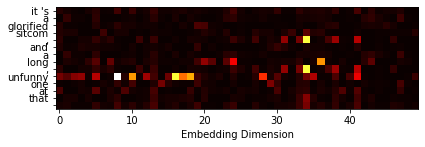

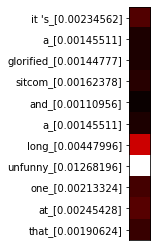

<Figure size 432x288 with 0 Axes>

In [16]:
clean_symbols=True
plot_averaged_saliency=True
for i in range(len(samples)):
    if i >0:break
    subprocess.call(["python", "main.py", "-no-cuda", "-snapshot",
                     "snapshot/best_steps_1900.pt",
                     "-example_save_path",
                     "tmp_saved_data/",
                     "-predict_and_attack",
                     "{}".format(samples[i])
                    ])

    x_index = np.load('tmp_saved_data/x_index.npy',allow_pickle=True)
    pred_adv_lst = np.load('tmp_saved_data/pred_adv_lst.npy',allow_pickle=True)
    attacks_lst_PGDM = np.load('tmp_saved_data/attacks_lst_PGDM.npy',allow_pickle=True)
    text = np.load('tmp_saved_data/text.npy',allow_pickle=True)
    abs_attack_pgdm = np.absolute(np.sum(attacks_lst_PGDM,axis=0)[x_index])
    abs_attack_fgm = np.absolute(attacks_lst_PGDM[0][x_index])
    
    normalized_score = normalize_words(abs_attack_fgm).sum(axis=1).reshape(-1,1)
    text_with_score = [text[ii]+"_{}".format(normalized_score[ii]) for ii in range(len(text))]
    
    if clean_symbols:
        clean_ind = np.invert((text==',')+(text=='')+(text=='.'))
    else:
        clean_ind = np.ones((len(text),), dtype=bool)
#     print('clean_ind :',clean_ind )
    

#     if "plot_saliency_map" == True:
    fig = plt.figure()
    ax = fig.add_subplot()
    fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
    im = ax.imshow(normalize_words(abs_attack_fgm),cmap='hot')
#     im = ax.imshow((abs_attack_fgm),cmap='hot')
    ax.set_yticks(np.arange(len(text)))
    ax.set_yticklabels(text)
    ax.set_xlabel ('Embedding Dimension')

#     if "plot_averaged_saliency" == True:
    fig = plt.figure()
    ax = fig.add_subplot()
    fig.subplots_adjust(left=.15, bottom=.16, right=.99, top=.97)
    im = ax.imshow(normalized_score[clean_ind],cmap='hot')
    ax.set_yticks(np.arange(len(text[clean_ind])))
    ax.set_yticklabels(np.array(text_with_score)[clean_ind])
    plt.xticks([])
    plt.show()
    plt.savefig('results/sample_{}'.format(i))
